# How to train the Captions model?

Where we describe how we are training a caption model. The related `train.py` file should have the same steps but we are being a bit more descriptive here.

In [1]:
# common recipe to get access to the source inside src
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
##########################################################

import numpy as np
from pathlib import Path

from models.CaptionModalityClassifier import CaptionModalityClassifier # caption modality classifier
from dataset.MultimodalityDataModule import MultimodalityDataModule    # pytorch lightning data module for captions and images
from utils.caption_utils import load_glove_matrix                      # utils for embeddings

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

## Loading data and stuff

Some hyperparameters are binded to the embedding dictionary to use. For instance, **Glove** has embeddings of 50, 100, ... 300 dimensions; we could experiment with them but cannot input a different value. Also, the vocabulary size will be somehow limited by the embedding dictionary and the training data. See that we specify a max vocab size of 20,000 words, but our caption data under Glove gives us around 7,500 words, so we are sticking to the number of words in the vocabulary after preprocessing the cpations. `This may be a good place to experiment with something different, it seems that many words are just dropped for not being in Glove`. Finally, the maximum number of words per sentence is another interesting value; our caption data has a (raw) mean around 700 with a long tail to the right (up to 3,000 characters).

In [2]:
MAX_NUMBER_WORDS = 20000       # number of words to consider from embeddings vocabulary
MAX_WORDS_PER_SENTENCE = 300   # sentence maximum length
WORD_DIMENSION = 300           # number of features per embedding
NUM_CLASSES = 4                # 4 microscopy classes
NUM_FILTERS = 100              # number of filters use in the ConvText module

BASE_PATH = Path('/workspace/data')
DATA_PATH = BASE_PATH / 'multimodality_classification.csv'
EMBEDDINGS = BASE_PATH / 'embeddings'
OUTPUT_DIR = Path('./outputs')
BASE_IMG_DIR = BASE_PATH       # the image path in the CSV file are relative to this directory
BATCH_SIZE = 32
LR = 1e-4
PROJECT = 'biomedical-multimodal'

NUM_WORKERS = 72               # workers on the cluster, normally... 4?

The data module takes care of the preprocessing and creation of the dataloaders. We can now access the dataloaders using `train|val|test_dataloader()`, though this is handled internally by the trainer.

In [3]:
dm = MultimodalityDataModule(BATCH_SIZE,
                             str(DATA_PATH),
                             MAX_NUMBER_WORDS,
                             MAX_WORDS_PER_SENTENCE,
                             str(BASE_IMG_DIR),
                             num_workers=NUM_WORKERS)
dm.prepare_data()
dm.setup()

print("Current vocabulary size: {0}".format(dm.vocab_size))
train_dataloader = dm.train_dataloader()
train_dataset    = train_dataloader.dataset
target_classes   = train_dataset.le.classes_
print("Classes: {0}".format(target_classes))

Current vocabulary size: 7221
Classes: ['DMEL' 'DMFL' 'DMLI' 'DMTR']


Then, we need to handle the embeddings matrix.

In [4]:
if dm.vocab_size < MAX_NUMBER_WORDS:
    MAX_NUMBER_WORDS = dm.vocab_size

embeddings_matrix = load_glove_matrix(EMBEDDINGS, WORD_DIMENSION, MAX_NUMBER_WORDS, dm.word_index)

Dimension: 300; found 400000 word vectors.
Embedding matrix shape: (7221, 300), with 2000 not present


In [10]:
dm.word_index

{'the': 1,
 'of': 2,
 'and': 3,
 'in': 4,
 '.': 5,
 'a': 6,
 'with': 7,
 'cells': 8,
 'c': 9,
 'b': 10,
 'd': 11,
 'to': 12,
 'were': 13,
 'for': 14,
 'is': 15,
 'e': 16,
 'f': 17,
 'î¼': 18,
 'by': 19,
 'are': 20,
 '2': 21,
 'from': 22,
 'at': 23,
 'h': 24,
 'cell': 25,
 'was': 26,
 'expression': 27,
 'g': 28,
 '1': 29,
 'm': 30,
 'staining': 31,
 'red': 32,
 'or': 33,
 'green': 34,
 'as': 35,
 'images': 36,
 'stained': 37,
 'scale': 38,
 'm.': 39,
 'anti': 40,
 'positive': 41,
 '3': 42,
 'arrows': 43,
 'bar': 44,
 'arrow': 45,
 'control': 46,
 '10': 47,
 'on': 48,
 'after': 49,
 'shown': 50,
 'i': 51,
 'magnification': 52,
 'that': 53,
 'an': 54,
 'sections': 55,
 '4': 56,
 'image': 57,
 'î±': 58,
 'p': 59,
 'nuclei': 60,
 'panel': 61,
 'not': 62,
 'î²': 63,
 'arrowheads': 64,
 'labeled': 65,
 'show': 66,
 '100': 67,
 'treated': 68,
 'showing': 69,
 'gfp': 70,
 'panels': 71,
 'blue': 72,
 'bars': 73,
 'mice': 74,
 'normal': 75,
 '20': 76,
 'electron': 77,
 'ï¿½ï¿½': 78,
 'antibody': 

In [5]:
MAX_NUMBER_WORDS

7221

## Learning rate finder

As we want the model to log the confusion matrix to the cloud, its handy to pass the `target_classes` as a parameter. There may be a way to access the module from the callbacks in Pytorch Lightning but I haven't find it yet.

In [12]:
model = CaptionModalityClassifier(
                 max_input_length=MAX_WORDS_PER_SENTENCE,
                 vocab_size=MAX_NUMBER_WORDS,
                 embedding_dim=WORD_DIMENSION,
                 filters=NUM_FILTERS,
                 embeddings=embeddings_matrix,
                 num_classes=NUM_CLASSES,
                 target_classes=target_classes,
                 train_embeddings=True,
                 lr=1e-4)

`pl` implements the one-cycle learning approach to find an initial learning rate. Now, I'm not sure how I feel about the different range of values that I have gotten by rerunning this function. However, using `1-e4` has produced a smooth curve...

In [13]:
# https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html
trainer = Trainer(gpus=1)
lr_finder = trainer.lr_find(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | CNNText | CNNTextBackbone | 2 M   
1 | fc      | Linear          | 1 K   


Saving latest checkpoint..
LR finder stopped early due to diverging loss.


0.008317637711026709


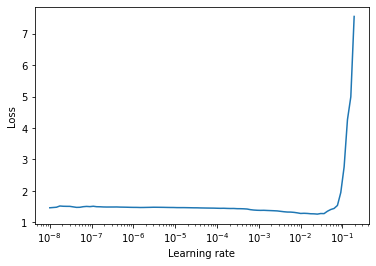

In [14]:
fig = lr_finder.plot(); fig.show()
suggested_lr = lr_finder.suggestion()
print(suggested_lr)

## Train the model

In [6]:
model = CaptionModalityClassifier(
                 max_input_length=MAX_WORDS_PER_SENTENCE,
                 vocab_size=MAX_NUMBER_WORDS,
                 embedding_dim=WORD_DIMENSION,
                 filters=NUM_FILTERS,
                 embeddings=embeddings_matrix,
                 num_classes=NUM_CLASSES,
                 target_classes=target_classes,
                 train_embeddings=True,
                 lr=LR)

# Creating the context for the weight and biases logger
wandb_logger = WandbLogger(project=PROJECT, tags=['nb', 'captions-only'])
wandb_logger.experiment.save()
print(wandb_logger.experiment.name)

output_run_path = OUTPUT_DIR / wandb_logger.experiment.name 
os.makedirs(output_run_path, exist_ok=False)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=5,
    verbose=True,
    mode='min'
)

trainer = Trainer(gpus=1,
                  max_epochs=50,
                  default_root_dir=str(output_run_path),
                  early_stop_callback=early_stop_callback,
                  logger=wandb_logger)
trainer.fit(model, dm)
trainer.save_checkpoint(str(output_run_path / 'final.pt'))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


snowy-jazz-8



  | Name    | Type            | Params
--------------------------------------------
0 | CNNText | CNNTextBackbone | 2 M   
1 | fc      | Linear          | 1 K   


Saving latest checkpoint..
Epoch 00032: early stopping triggered.


## Test the model

Test uses the test_step and test_epoch_end functions on the model, and obtain the dataset from the test dataloader. Certainly, we can modify the dataloader to use the validation settings for test while experimenting.

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Accuracy: 62.19931411743164
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(62.1993, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_acc': 62.19931411743164}]

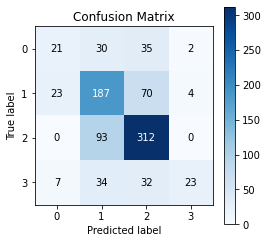

In [7]:
trainer.test(model)